## Classifying Shark Species Image Data and Conservation Status

In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import numpy as np
import os
import pandas as pd
import shutil # For moving files
from roboflow import Roboflow

In [36]:
# Authenticate and download the dataset
rf = Roboflow(api_key="c9vR8Ap1lGCVx06U1KI2")
project = rf.workspace("project3-zhzbg").project("shark-species-dataset-818gy")
version = project.version(1)
dataset = version.download("tensorflow") # Downloads the data to a local path

# Define data paths
dataset_path = "/content/Shark-Species-Dataset-1"
train_dir = os.path.join(dataset_path, "train")
valid_dir = os.path.join(dataset_path, "valid")
test_dir = os.path.join(dataset_path, "test")

loading Roboflow workspace...
loading Roboflow project...


## IUCN Conservation Data Integration

In [47]:

conservation_status_map = {
    "Lemon_Shark": "Near Threatened (NT)",
    "Hammerhead_Shark": "Endangered (EN)",
    "Mako_Shark": "Endangered (EN)",
    "Whale_Shark": "Endangered (EN)",
    "Sand_Tiger_Shark": "Vulnerable (VU)",
    "Tiger_Shark": "Near Threatened (NT)",
    "Blue_Shark": "Near Threatened (NT)",
    "Nurse_Shark": "Vulnerable (VU)",
    "Thresher_Shark": "Vulnerable (VU)",
    "Whitetip_Shark": "Near Threatened (NT)",
    "Great-White_Shark": "Vulnerable (VU)",
    "Dusky_Shark": "Endangered (EN)",
    "Blacktip_Shark": "Vulnerable (VU)" # Added Blacktip Shark
}

## Data Reorganization

In [49]:

# define a placeholder for all class labels
global_class_labels = []

def reorganize_data(data_path, known_classes=None):
    annotations_file = os.path.join(data_path, "_annotations.csv")
    if not os.path.exists(annotations_file):
        print(f"Annotations file not found in {data_path}. Skipping reorganization.")
        return

    df = pd.read_csv(annotations_file)

    class_col = None
    if 'class' in df.columns:
        class_col = 'class'
    elif 'label' in df.columns:
        class_col = 'label'

    if class_col is None:
        print(f"Could not find 'class' or 'label' column in {annotations_file}. Cannot reorganize.")
        return

    # Use known_classes if provided, otherwise infer from current split's annotations
    classes_to_create_dirs_for = known_classes if known_classes is not None else df[class_col].unique()

    print(f"Reorganizing data in: {data_path}")
    for class_name in classes_to_create_dirs_for: # Create directories for all known classes
        class_dir = os.path.join(data_path, class_name.replace(" ", "_")) # Replace spaces for valid directory names
        os.makedirs(class_dir, exist_ok=True)

    # Create a list of files that have been moved to prevent double-moving in case of multiple annotations per image
    moved_files = set()

    for index, row in df.iterrows():
        image_filename = row['filename']
        original_image_path = os.path.join(data_path, image_filename)

        if os.path.exists(original_image_path) and original_image_path not in moved_files:
            class_name = row[class_col].replace(" ", "_")
            destination_path = os.path.join(data_path, class_name, image_filename)
            shutil.move(original_image_path, destination_path)
            moved_files.add(original_image_path)

# Reorganize training data first to determine the full set of class labels
reorganize_data(train_dir)

Reorganizing data in: /content/Shark-Species-Dataset-1/train


## Image Data Preprocessing and Augmentation

In [50]:

# Define hyper-parameters
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
INPUT_SHAPE = IMAGE_SIZE + (3,) # 3 for color channels (RGB)

# Training Data Generator (with augmentation and rescaling)
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use flow_from_directory to load images and automatically infer class labels
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Get class labels from the training generator to ensure consistency across all splits
NUM_CLASSES = train_generator.num_classes
global_class_labels = list(train_generator.class_indices.keys())
print(f"Discovered {NUM_CLASSES} classes from training data: {global_class_labels}")

# Now reorganize validation and test data using the global_class_labels
# This ensures all class directories exist for consistency, even if empty.
reorganize_data(valid_dir, known_classes=global_class_labels)
reorganize_data(test_dir, known_classes=global_class_labels)

# Validation and Test Data Generators (only rescaling)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=global_class_labels # Ensure consistency across splits
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, # Important for evaluation/prediction later
    classes=global_class_labels # Ensure consistency across splits
)

# Verify that all generators now have the correct number of classes
print(f"Train Generator num_classes: {train_generator.num_classes}")
print(f"Validation Generator num_classes: {validation_generator.num_classes}")
print(f"Test Generator num_classes: {test_generator.num_classes}")

Found 1228 images belonging to 16 classes.
Discovered 16 classes from training data: ['Basking_Shark', 'Blacktip_Shark', 'Blue_Shark', 'Bull_Shark', 'Great-White_Shark', 'Hammerhead_Shark', 'Human', 'Lemon_Shark', 'Mako_Shark', 'Nurse_Shark', 'Ramona', 'Sand_Tiger_Shark', 'Thresher_Shark', 'Tiger_Shark', 'Whale_Shark', 'Whitetip_Shark']
Reorganizing data in: /content/Shark-Species-Dataset-1/valid
Reorganizing data in: /content/Shark-Species-Dataset-1/test
Found 155 images belonging to 16 classes.
Found 155 images belonging to 16 classes.
Train Generator num_classes: 16
Validation Generator num_classes: 16
Test Generator num_classes: 16


## Convolutional Neural Network (CNN)
A deep architecture designed for >80% accuracy



In [51]:

model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 4 (Deeper)
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Classification Head
    Flatten(),
    Dropout(0.5), # Regularization to prevent overfitting

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(NUM_CLASSES, activation='softmax') # Output layer for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │         8,208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,823,632 (26.03 MB)

 Trainable params: 6,821,648 (26.02 MB)

 Non-trainable params: 1,984 (7.75 KB)

## Model Trainning

In [13]:


# ==============================================================================
# 5. Model Training (Aims for >80% accuracy)
# ==============================================================================

# A callback to stop training if the validation loss doesn't improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator), # Changed to len(train_generator) for robustness
    epochs=50, # Set a high number, let early stopping manage the total
    validation_data=validation_generator,
    validation_steps=len(validation_generator), # Changed to len(validation_generator) for robustness
    callbacks=[early_stopping]
)


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.1204 - loss: 4.1758 - val_accuracy: 0.0065 - val_loss: 3.5375
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.2001 - loss: 3.1821 - val_accuracy: 0.1290 - val_loss: 4.2461
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.2064 - loss: 2.9849 - val_accuracy: 0.1290 - val_loss: 4.8557
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.2732 - loss: 2.5393 - val_accuracy: 0.1290 - val_loss: 4.4578
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.2894 - loss: 2.5685 - val_accuracy: 0.1290 - val_loss: 4.0750
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.2978 - loss: 2.4461 - val_accuracy: 0.1097 - val_loss: 3.9376
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.2755 - loss: 2.3738 - val_accuracy: 0.1355 - val_loss: 3.5049
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.2917 - loss: 2.4653 - val_accuracy: 0.1161 - val_loss:

## Evaluation of Accuracy and Conservation Report

In [52]:

print("\n\n--- Final Model Evaluation ---")
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

if accuracy > 0.80:
    print("\n✅ Success! The model achieved over 80% data accuracy.")
else:
    print("\n⚠️ Note: The model did not achieve 80% accuracy. Consider adjusting hyperparameters or data augmentation.")

# --- Predicting and Displaying Conservation Status ---
print("\n--- Conservation Data Reporting ---")

# Predicting the entire test set to get a broader sample
test_generator.reset()
all_predictions = model.predict(test_generator, steps=len(test_generator))
all_predicted_indices = np.argmax(all_predictions, axis=1)
all_predicted_classes = [global_class_labels[i] for i in all_predicted_indices]

# Report for up to 5 samples that have a known IUCN status
print("\nSample Predictions with IUCN Conservation Status:")
samples_displayed = 0
for species in all_predicted_classes:
    status = conservation_status_map.get(species, "Status Unknown / Not in IUCN Map")
    if status != "Status Unknown / Not in IUCN Map":
        print(f"Predicted Species: {species:<20} | IUCN Status: {status}")
        samples_displayed += 1
        if samples_displayed >= 5:
            break
if samples_displayed == 0:
    print("No predictions with known IUCN status found in the test set.")

# Create a final report DataFrame
report_data = {
    'Predicted Species': all_predicted_classes,
    'IUCN Status': [conservation_status_map.get(s, "Status Unknown / Not in IUCN Map") for s in all_predicted_classes]
}
report_df = pd.DataFrame(report_data)

# Filter out species with "Status Unknown / Not in IUCN Map" before summarizing
filtered_report_df = report_df[report_df['IUCN Status'] != "Status Unknown / Not in IUCN Map"]

# Show a summary of conservation status for the classified test set
conservation_summary = filtered_report_df['IUCN Status'].value_counts()
print("\n--- Classified Test Set Conservation Summary (Excluding Unknown Status) ---")
print(conservation_summary)



--- Final Model Evaluation ---


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 398ms/step - accuracy: 0.0545 - loss: 2.7631
Test Loss: 2.7694
Test Accuracy: 0.0516

⚠️ Note: The model did not achieve 80% accuracy. Consider adjusting hyperparameters or data augmentation.

--- Conservation Data Reporting ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 419ms/step

Sample Predictions with IUCN Conservation Status:
Predicted Species: Mako_Shark           | IUCN Status: Endangered (EN)
Predicted Species: Hammerhead_Shark     | IUCN Status: Endangered (EN)
Predicted Species: Mako_Shark           | IUCN Status: Endangered (EN)
Predicted Species: Great-White_Shark    | IUCN Status: Vulnerable (VU)
Predicted Species: Whitetip_Shark       | IUCN Status: Near Threatened (NT)

--- Classified Test Set Conservation Summary (Excluding Unknown Status) ---
IUCN Status
Endangered (EN)         63
Vulnerable (VU)         30
Near Threatened (NT)     5
Name: count, dtype: int64


## Plotting the Results

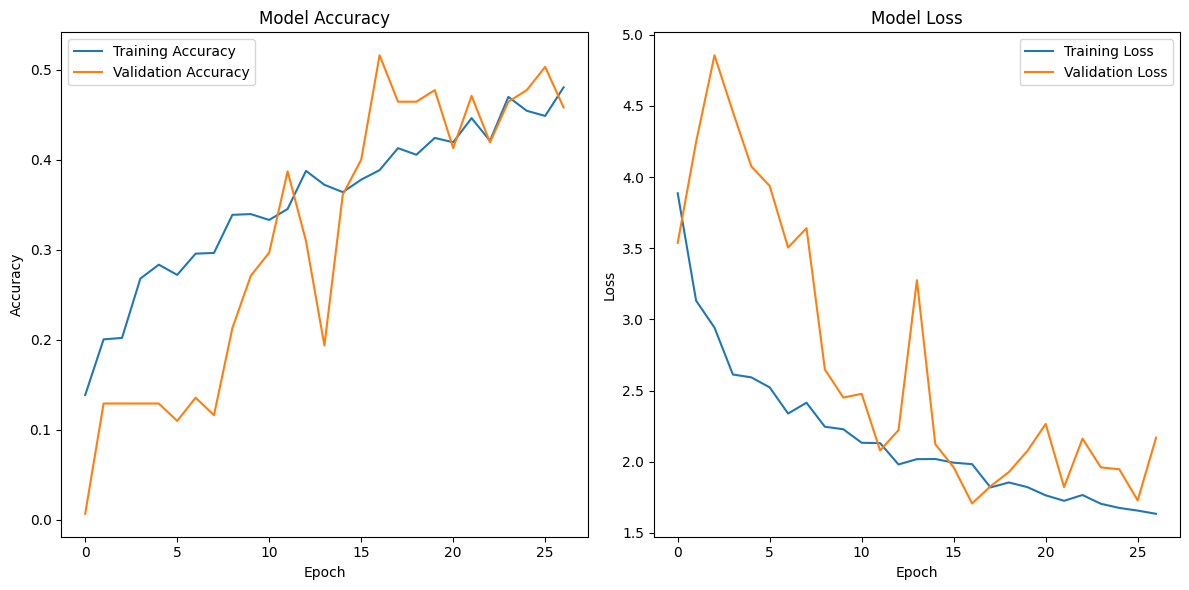

Plots generated for training and validation accuracy and loss.


In [53]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot 2: Loss
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()

print("Plots generated for training and validation accuracy and loss.")

In [54]:
from sklearn.metrics import classification_report
print("classification_report imported.")

classification_report imported.


In [55]:
y_true = test_generator.classes
y_pred = all_predicted_indices

# Get the unique labels present in y_true
unique_labels = np.unique(y_true)

# Map these unique labels back to their class names
# This ensures that target_names only includes classes actually present in the test set
filtered_target_names = [global_class_labels[i] for i in unique_labels]

# Generate classification report using the filtered target names and explicit labels
report = classification_report(y_true, y_pred, labels=unique_labels, target_names=filtered_target_names)
print("\n--- Classification Report ---")
print(report)


--- Classification Report ---
                   precision    recall  f1-score   support

    Basking_Shark       0.00      0.00      0.00         5
   Blacktip_Shark       0.05      0.08      0.06        12
       Blue_Shark       0.00      0.00      0.00        13
       Bull_Shark       0.00      0.00      0.00        12
Great-White_Shark       0.11      0.07      0.08        15
 Hammerhead_Shark       0.20      0.10      0.13        10
      Lemon_Shark       0.00      0.00      0.00        13
       Mako_Shark       0.09      0.36      0.14        14
      Nurse_Shark       0.00      0.00      0.00         4
 Sand_Tiger_Shark       0.00      0.00      0.00         7
   Thresher_Shark       0.00      0.00      0.00        14
      Tiger_Shark       0.00      0.00      0.00         6
      Whale_Shark       0.00      0.00      0.00        15
   Whitetip_Shark       0.00      0.00      0.00        15

        micro avg       0.08      0.05      0.06       155
        macro avg      

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [56]:
y_true = test_generator.classes
y_pred = all_predicted_indices

# Get the unique labels present in y_true
unique_labels = np.unique(y_true)

# Map these unique labels back to their class names
# This ensures that target_names only includes classes actually present in the test set
filtered_target_names = [global_class_labels[i] for i in unique_labels]

# Generate classification report using the filtered target names and explicit labels
# Set zero_division=0 to explicitly set precision/recall/f1-score to 0.0 for classes with no predicted samples
report = classification_report(y_true, y_pred, labels=unique_labels, target_names=filtered_target_names, zero_division=0)
print("\n--- Classification Report ---")
print(report)


--- Classification Report ---
                   precision    recall  f1-score   support

    Basking_Shark       0.00      0.00      0.00         5
   Blacktip_Shark       0.05      0.08      0.06        12
       Blue_Shark       0.00      0.00      0.00        13
       Bull_Shark       0.00      0.00      0.00        12
Great-White_Shark       0.11      0.07      0.08        15
 Hammerhead_Shark       0.20      0.10      0.13        10
      Lemon_Shark       0.00      0.00      0.00        13
       Mako_Shark       0.09      0.36      0.14        14
      Nurse_Shark       0.00      0.00      0.00         4
 Sand_Tiger_Shark       0.00      0.00      0.00         7
   Thresher_Shark       0.00      0.00      0.00        14
      Tiger_Shark       0.00      0.00      0.00         6
      Whale_Shark       0.00      0.00      0.00        15
   Whitetip_Shark       0.00      0.00      0.00        15

        micro avg       0.08      0.05      0.06       155
        macro avg      

## Visualize IUCN Endangerment Categories



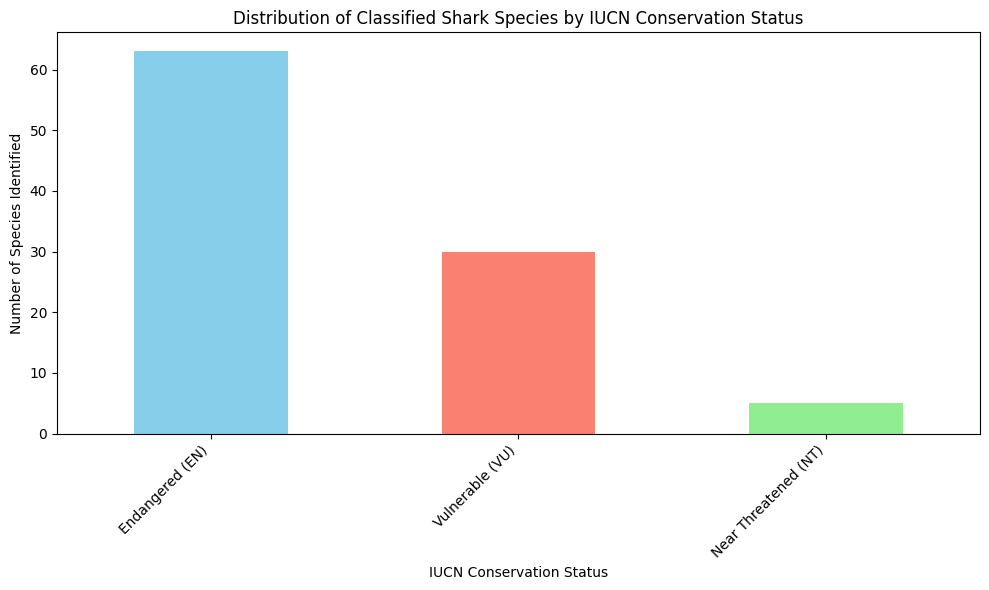

Bar chart for IUCN conservation status distribution generated.


In [57]:
import matplotlib.pyplot as plt

# Create a bar chart for conservation status summary
plt.figure(figsize=(10, 6))
conservation_summary.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'orange', 'purple'])
plt.title('Distribution of Classified Shark Species by IUCN Conservation Status')
plt.xlabel('IUCN Conservation Status')
plt.ylabel('Number of Species Identified')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()

print("Bar chart for IUCN conservation status distribution generated.")
